# Project 3: Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import re
import plotly.express as px

## Preliminary data analysis

In [2]:
# Data reading
hotels = pd.read_csv('data/hotels.csv')
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [3]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

Only *lat* and *lng* features have nans.

In [4]:
# Statistics of numeric features
hotels.describe().round(2)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.00,386803.00,386803.00,386803.00,386803.00,386803.00,386803.00,384355.00,384355.00
mean,498.25,8.40,18.54,2743.99,17.78,7.18,8.40,49.44,2.82
std,500.26,0.55,29.70,2316.46,21.73,11.05,1.64,3.47,4.58
min,1.00,5.20,0.00,43.00,0.00,1.00,2.50,41.33,-0.37
25%,169.00,8.10,2.00,1161.00,5.00,1.00,7.50,48.21,-0.14
50%,342.00,8.40,9.00,2134.00,11.00,3.00,8.80,51.50,-0.00
75%,660.00,8.80,23.00,3613.00,22.00,8.00,9.60,51.52,4.83
max,2682.00,9.80,408.00,16670.00,395.00,355.00,10.00,52.40,16.43


In [5]:
# Statistics of categorical features
hotels.describe(exclude=np.number)

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,386803,386803,386803,386803,386803,386803,386803,386803
unique,1493,731,1492,225,248828,311737,47135,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,3587,1911,3587,184033,95907,26885,3853,1911


## Feature engineering

In [6]:
import scipy.stats as stats

# significance level
alpha = 0.05

Dataset separation:

In [7]:
# X - features for training, y - target (hotel rating) 
X = hotels.drop(['reviewer_score'], axis = 1)
y = hotels['reviewer_score']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

### Hotel Address

Extract information about city

In [8]:
X['city'] = X['hotel_address'].apply(lambda x: x.split()[-5] if 'United Kingdom' in x \
    else x.split()[-2])
X['city'].value_counts(True) * 100

city
London       50.871891
Barcelona    11.667955
Paris        11.589879
Amsterdam    11.118321
Vienna        7.543375
Milan         7.208579
Name: proportion, dtype: float64

Encoding

In [9]:
import category_encoders as ce

In [10]:
encoder = ce.OneHotEncoder(cols=['city'], use_cat_names=True)
city_bin = encoder.fit_transform(X['city'])
X = pd.concat([X, city_bin], axis=1)

### Coordinates

In [11]:
from geopy.geocoders import Nominatim

Addresses lacking coordinates:

In [12]:
coordinates_na = X[X['lng'].isna() | X['lat'].isna()]['hotel_address'].unique()
coordinates_na

array(['Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
       '23 Rue Damr mont 18th arr 75018 Paris France',
       'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
       'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
       '4 rue de la P pini re 8th arr 75008 Paris France',
       'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
       'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
       'Bail n 4 6 Eixample 08010 Barcelona Spain',
       'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
       'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
       'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
       'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
       '20 Rue De La Ga t 14th arr 75014 Paris France',
       'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
       'Sep lveda 180 Eixample 08011 Barcelona Spain',
       'Pau Clar s 122 Eixample 08009 Barcelona Spain',
       'Josefst dter Stra e 22 08 Jos

Correct some *hotel_address* entries:

In [13]:
X['hotel_address'].replace({
    'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': 'Savoyenstraße 2, 16. Ottakring, 1160 Vienna, Austria',
    '23 Rue Damr mont 18th arr 75018 Paris France': '23, Rue Damrémont, 18e arrondissement, 75018 Paris, France',
    'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': 'Josefstädter Straße 10-12. Josefstadt, 1080 Vienna, Austria',
    'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': 'Währinger Straße 33-35. Alsergrund, 1090 Vienna, Austria',
    '4 rue de la P pini re 8th arr 75008 Paris France': '4, rue de la Pépinière, 8e arrondissement, 75008 Paris, France',
    'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': 'Sieveringer Straße 4, 19. Döbling, 1190 Vienna, Austria',
    'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': 'Taborstraße 8A. Leopoldstadt, 1020 Vienna, Austria',
    'Bail n 4 6 Eixample 08010 Barcelona Spain': 'Bailén, 4-6, Eixample, 08010 Barcelona, Spain',
    'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': 'Grünentorgasse, 30. Alsergrund, 1090 Vienna, Austria',
    'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': 'Landstraßer Gürtel 5. Landstraße, 1030 Vienna, Austria',
    'Paragonstra e 1 11 Simmering 1110 Vienna Austria': 'Paragonstraße 1, 11. Simmering, 1110 Vienna, Austria',
    'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': 'Währinger Straße 12. Alsergrund, 1090 Vienna, Austria',
    '20 Rue De La Ga t 14th arr 75014 Paris France': '20, Rue De La Gaîté, 14e arrondissement, 75014 Paris, France',
    'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': 'Hasenauerstraße 12, 19. Döbling, 1190 Vienna, Austria',
    'Sep lveda 180 Eixample 08011 Barcelona Spain': 'Sepúlveda 180, Eixample, 08011 Barcelona, Spain',
    'Pau Clar s 122 Eixample 08009 Barcelona Spain': 'Pau Clarís 122, Eixample, 08009 Barcelona, Spain',
    'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': 'Josefstädter Straße 22. Josefstadt, 1080 Vienna, Austria'
}, inplace=True)

Generate dictionary with keys as addresses and values as coordinates:

In [14]:
coordinates_na = list(X[X['lng'].isna() | X['lat'].isna()]['hotel_address'].unique())

geolocator = Nominatim(user_agent="hotel_locator")

locations_dict = dict()

for item in coordinates_na:
    location = geolocator.geocode(item)
    locations_dict[item] = [location.latitude, location.longitude]
    
locations_dict

{'Savoyenstraße 2, 16. Ottakring, 1160 Vienna, Austria': [48.219571,
  16.285625206638713],
 '23, Rue Damrémont, 18e arrondissement, 75018 Paris, France': [48.8888806,
  2.3331948],
 'Josefstädter Straße 10-12. Josefstadt, 1080 Vienna, Austria': [48.209235,
  16.355225],
 'Währinger Straße 33-35. Alsergrund, 1090 Vienna, Austria': [48.2203011,
  16.3558834],
 '4, rue de la Pépinière, 8e arrondissement, 75008 Paris, France': [48.875248,
  2.3233746],
 'Sieveringer Straße 4, 19. Döbling, 1190 Vienna, Austria': [48.2516561,
  16.320504901254935],
 'Taborstraße 8A. Leopoldstadt, 1020 Vienna, Austria': [48.2136122,
  16.380141833653525],
 'Bailén, 4-6, Eixample, 08010 Barcelona, Spain': [41.3927215, 2.1760747],
 'Grünentorgasse, 30. Alsergrund, 1090 Vienna, Austria': [48.2208351,
  16.366645],
 'Landstraßer Gürtel 5. Landstraße, 1030 Vienna, Austria': [48.1888627,
  16.3838516356697],
 'Paragonstraße 1, 11. Simmering, 1110 Vienna, Austria': [48.18672145,
  16.420653090404993],
 'Währinger S

Fill missing coordinates:

In [15]:
for key in locations_dict.keys():
    X.loc[X['hotel_address'] == key, 'lat'] = locations_dict[key][0]
    X.loc[X['hotel_address'] == key, 'lng'] = locations_dict[key][1]

### Hotel name

In [16]:
X['hotel_name'].nunique()

1492

It seems like we have 1492 unique hotel names. In part that's true, but some hotels share the same name.

In [17]:
name_address_df = X[['hotel_name', 'hotel_address']].drop_duplicates(ignore_index=True)
name_address_df.shape[0]

1494

We have 1494 records despite having 1492 unique hotel names.

In [18]:
name_address_df[name_address_df.duplicated(subset=['hotel_name'])]

,hotel_name,hotel_address
687,Hotel Regina,Rooseveltplatz 15 09 Alsergrund 1090 Vienna Au...
717,Hotel Regina,Via Cesare Correnti 13 Milan City Center 20123...


In [19]:
name_address_df[name_address_df['hotel_name'] == 'Hotel Regina']

,hotel_name,hotel_address
337,Hotel Regina,Bergara 2 4 Eixample 08002 Barcelona Spain
687,Hotel Regina,Rooseveltplatz 15 09 Alsergrund 1090 Vienna Au...
717,Hotel Regina,Via Cesare Correnti 13 Milan City Center 20123...


There are 3 separate hotels who share the name 'Hotel Regina'. Let's rename them respectively:

In [20]:
regina_city_arr = X[X['hotel_name'] == 'Hotel Regina']['city'].unique()

for item in regina_city_arr:
    X.loc[(X['city'] == item) & (X['hotel_name'] == 'Hotel Regina'), 'hotel_name'] = 'Hotel Regina (' + item + ')'

X['hotel_name'].nunique()

1494

### Additional number of scoring

In [21]:
hotel_df = X[['hotel_name', 'additional_number_of_scoring', 'average_score', 'total_number_of_reviews']].drop_duplicates(ignore_index=True)
hotel_df.head()

,hotel_name,additional_number_of_scoring,average_score,total_number_of_reviews
0,The May Fair Hotel,581,8.4,1994
1,Mercure London Bloomsbury Hotel,299,8.3,1361
2,Legend Saint Germain by Elegancia,32,8.9,406
3,Mercure Paris 19 Philharmonie La Villette,34,7.5,607
4,Golden Tulip Amsterdam West,914,8.5,7586


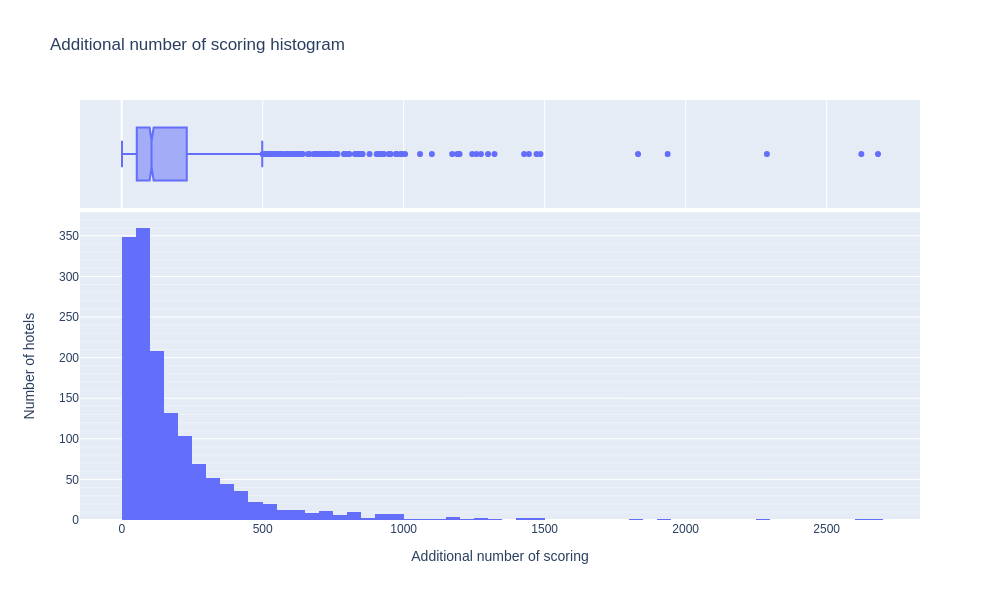

In [22]:
fig_add_number = px.histogram(
    hotel_df['additional_number_of_scoring'],
    height=600,
    width=1000,
    marginal='box',
    title="Additional number of scoring histogram"
)
fig_add_number.update_layout(showlegend=False)
fig_add_number.update_yaxes(minor_showgrid=True)
fig_add_number.layout.xaxis.title.text = 'Additional number of scoring'
fig_add_number.layout.yaxis.title.text = 'Number of hotels'
fig_add_number.write_html('images/add_scoring.html')
fig_add_number.write_image('images/add_scoring.png')
fig_add_number.show('png')
#fig_add_number.show()

### Average score

Check if average score is normally distributed:

In [23]:
# normality check function
def decision_normality(p):
    print(f'p-value - {p:.3f}')
    if p <= alpha:
        print(f'p-value is less than significance level {alpha:.2f}. Distribution is not normal.')
        return False
    else:
        print(f'p-value is greater than significance level {alpha:.2f}. Distribution is normal.')
        return True

In [24]:
decision_normality(stats.shapiro(hotel_df['average_score'])[1])

p-value - 0.000
p-value is less than significance level 0.05. Distribution is not normal.


False

In [25]:
def outliers_iqr_log(data, feature, left = 1.5, right = 1.5, log_scale = False):
	"""Clean data, quantile method

	Args:
		data (pandas.Dataframe): original dataframe
		feature (string): name of feature to clean
		left (float, optional): left boundary. Defaults to 1.5.
		right (float, optional): right boundary. Defaults to 1.5.
		log_scale (bool, optional): logarithmical scale. Defaults to False.

	Returns:
		pandas.Dataframe: purged data, filtered data
	"""
	if log_scale:
		x = np.log(data[feature])
	else:
		x = data[feature]

	quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
	iqr = quartile_3 - quartile_1
	lower_bound = quartile_1 - (iqr * left)
	upper_bound = quartile_3 + (iqr * right)
	outliers = data[(x < lower_bound) | (x > upper_bound)]
	cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
 
	return outliers, cleaned

In [26]:
outliers_score, cleaned_score = outliers_iqr_log(hotel_df, 'average_score', left=2, right=1.5)

# number of outliers
outliers_score.shape[0]

3

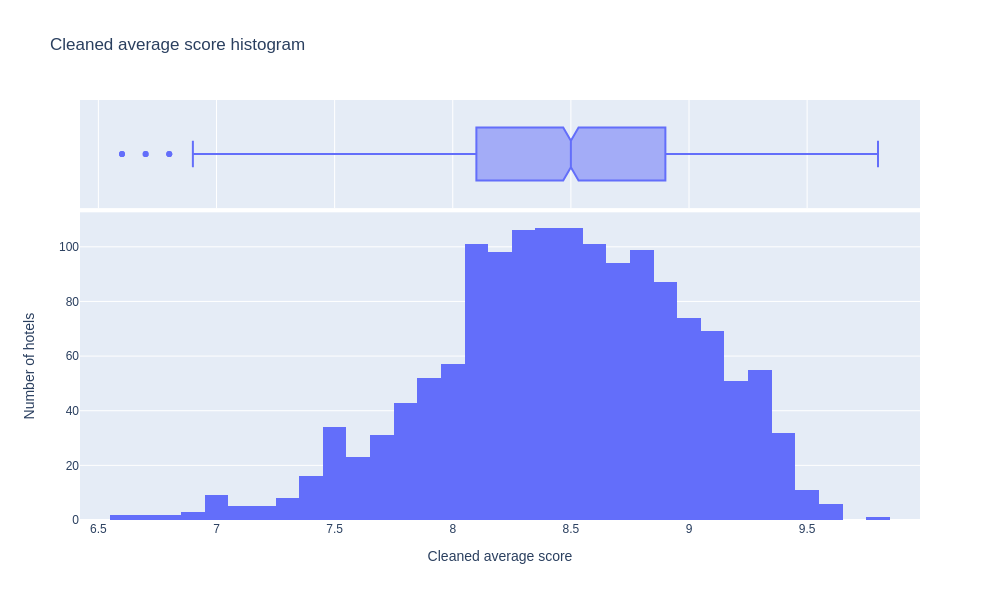

In [27]:
fig_score_cleaned = px.histogram(
    cleaned_score['average_score'],
    height=600,
    width=1000,
    marginal='box',
    title="Cleaned average score histogram"
)
fig_score_cleaned.update_layout(showlegend=False)
fig_score_cleaned.layout.xaxis.title.text = 'Cleaned average score'
fig_score_cleaned.layout.yaxis.title.text = 'Number of hotels'
fig_score_cleaned.write_html('images/average_score_cleaned.html')
fig_score_cleaned.write_image('images/average_score_cleaned.png')
fig_score_cleaned.show('png')
#fig_score_cleaned.show()

In [28]:
outliers_score

,hotel_name,additional_number_of_scoring,average_score,total_number_of_reviews
596,Hotel Cavendish,369,6.4,2275
999,Savoy Hotel Amsterdam,114,6.4,995
1167,Hotel Liberty,26,5.2,465


In [29]:
X[X['hotel_name'] == 'Hotel Liberty'][['positive_review', 'negative_review']]

,positive_review,negative_review
5666,The stuff was extremely nice The breakfast wa...,The shower water pressure was absolutely miss...
18895,The Wi Fi was reachable near the lobby The ro...,No Negative
28330,Breakfast is good Weekday staff is very kind ...,Shower box is not provided enough water and t...
42524,Location is not bad,Not clean no wi fi in rooms Old furniture and...
48461,No Positive,Very dirty poorly staffed Airconditioners do ...
51081,No Positive,Staff not welcoming at all Bad smell of cigar...
64706,Have stayed there at least 4 times Size of mo...,Hotel looks tired and requires some updates i...
75164,hotel was empty like having a private hotel,no wi fi in the room
80268,The room was clean,Our bed wasn t made the next day The AC didn ...
93707,No Positive,run down hotel with unmotivated staff


Since "outlying" hotels have many negative reviews, we have no reason to ignore these records.

### Total number of reviews

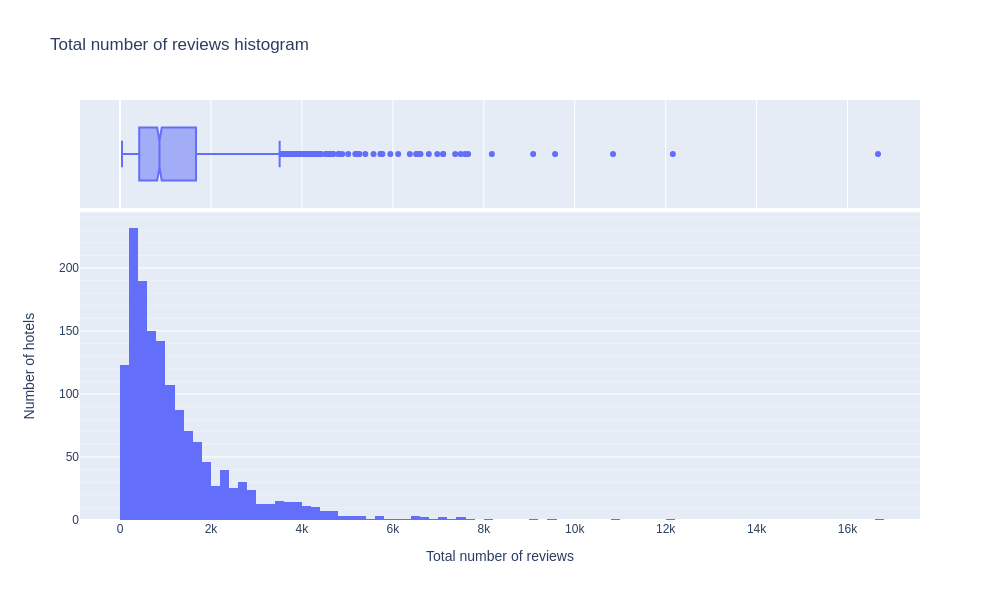

In [30]:
fig_num_review = px.histogram(
    hotel_df['total_number_of_reviews'],
    height=600,
    width=1000,
    marginal='box',
    title="Total number of reviews histogram"
)
fig_num_review.update_layout(showlegend=False)
fig_num_review.update_yaxes(minor_showgrid=True)
fig_num_review.layout.xaxis.title.text = 'Total number of reviews'
fig_num_review.layout.yaxis.title.text = 'Number of hotels'
fig_num_review.write_html('images/total_reviews.html')
fig_num_review.write_image('images/total_reviews.png')
fig_num_review.show('png')
#fig_num_review.show()

Correlation between numeric features in *hotel_df*:

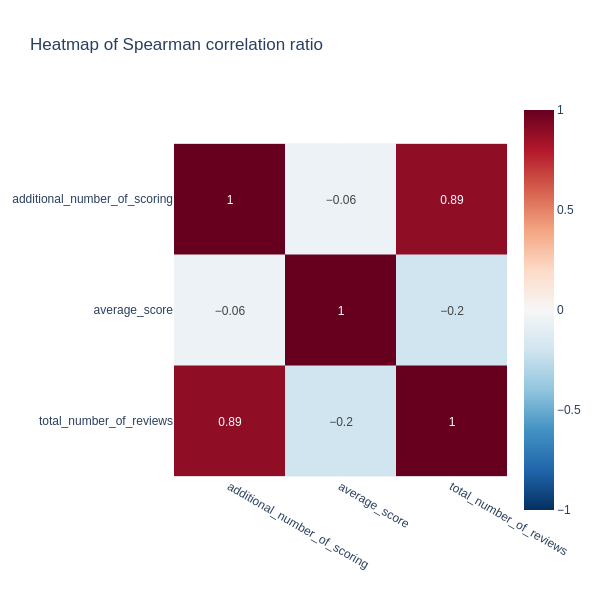

In [31]:
fig_numeric_corr = px.imshow(
    round(hotel_df.select_dtypes(include=[np.number]).corr(method='spearman'), 2),
    text_auto=True,
    range_color=[-1, 1],
    title='Heatmap of Spearman correlation ratio',
    width=600,
    height=600,
    color_continuous_scale=px.colors.sequential.RdBu_r
)
fig_numeric_corr.update_layout(showlegend=False)
fig_numeric_corr.write_html('images/numeric_corr.html')
fig_numeric_corr.write_image('images/numeric_corr.png')
fig_numeric_corr.show('png')
#fig_numeric_corr.show()

Since all of the numeric features has not normal distribution, we have implemented Spearman correlation.

*Total number of reviews* and *additional number of scoring* have strong correlation. Average score has faint negative correlation with the rest of numeric features. If there is some cheating involved, its scale is insignificant.

### Review date

Convert type of data to datetime

In [32]:
X['review_date'] = pd.to_datetime(X['review_date'])
X['review_date'].head()

0   2016-02-19
1   2017-01-12
2   2016-10-18
3   2015-09-22
4   2016-03-05
Name: review_date, dtype: datetime64[ns]

Extract information about year, month, day of week, day of month

In [33]:
X['review_year'] = X['review_date'].dt.year
X['review_month'] = X['review_date'].dt.month
X['review_day_week'] = X['review_date'].dt.day_of_week
X['review_day_month'] = X['review_date'].dt.day
X[['review_year', 'review_month', 'review_day_week', 'review_day_month']].head()

,review_year,review_month,review_day_week,review_day_month
0,2016,2,4,19
1,2017,1,3,12
2,2016,10,1,18
3,2015,9,1,22
4,2016,3,5,5


### Reviewer nationality

In [34]:
X['reviewer_nationality'].nunique()

225

In [35]:
X['reviewer_nationality'].value_counts(True)[:10] * 100

reviewer_nationality
 United Kingdom               47.577966
 United States of America      6.861632
 Australia                     4.198261
 Ireland                       2.876400
 United Arab Emirates          1.969219
 Saudi Arabia                  1.737836
 Netherlands                   1.708363
 Switzerland                   1.679925
 Canada                        1.547041
 Germany                       1.539802
Name: proportion, dtype: float64

Create new features representing most common nationalities

In [36]:
X['reviewer_from_UK'] = X['reviewer_nationality'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

### Negative review

In [37]:
X['negative_review'].nunique()

248828

Some preprocessing operations:

In [38]:
# Delete redundant spaces and convert text to lowercase
X['negative_review'] = X['negative_review'].apply(lambda x: x.strip(' ').lower())

In [39]:
# Deal with 's and 't wrong interpretation
X['negative_review'] = X['negative_review'].apply(lambda x: x.replace(' t ', 't '))
X['negative_review'] = X['negative_review'].apply(lambda x: x.replace(' s ', 's '))

In [40]:
# Word counter in negative reviews
X['neg_review_wc'] = X['negative_review'].apply(lambda x: len(re.findall(r"[\w']+", x)))
X[['negative_review', 'neg_review_wc']].head()

,negative_review,neg_review_wc
0,leaving,1
1,poor breakfast,2
2,no kettle in room,4
3,no negative,2
4,torn sheets,2


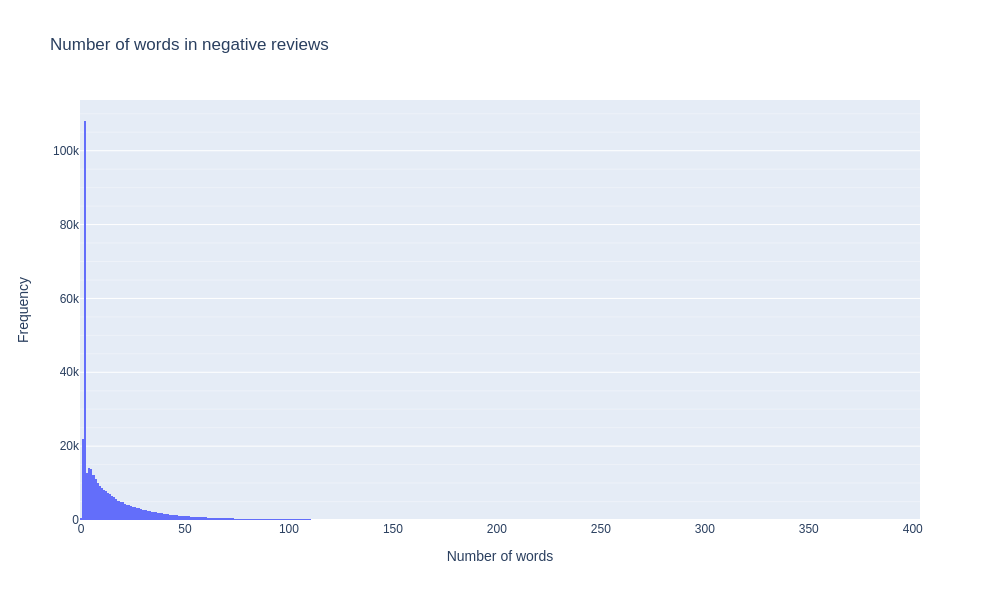

In [41]:
fig_neg_wc = px.histogram(
    X['neg_review_wc'],
    height=600,
    width=1000,
    title="Number of words in negative reviews"
)
fig_neg_wc.update_layout(showlegend=False)
fig_neg_wc.update_yaxes(minor_showgrid=True)
fig_neg_wc.layout.xaxis.title.text = 'Number of words'
fig_neg_wc.layout.yaxis.title.text = 'Frequency'
fig_neg_wc.write_html('images/neg_wc.html')
fig_neg_wc.write_image('images/neg_wc.png')
fig_neg_wc.show('png')
#fig_neg_wc.show()

Overwhelming number of reviews consists of very short number of words. Such reviews usually contain no negative content at all. Those of reviews which have long duration typically describe some features displeasing the reviewer.

In [42]:
neg_review_list = X['negative_review'].apply(lambda x: x.split())
neg_review_list.head()

0                 [leaving]
1         [poor, breakfast]
2    [no, kettle, in, room]
3            [no, negative]
4            [torn, sheets]
Name: negative_review, dtype: object

The main idea is to match 20 most popular words in negative reviews that can affect the hotel rating.

In [43]:
neg_words_list = neg_review_list.explode()
neg_words_list.head()

0      leaving
1         poor
1    breakfast
2           no
2       kettle
Name: negative_review, dtype: object

In [44]:
neg_words_cnt = pd.value_counts(neg_words_list)
neg_words_cnt.head(20)

negative_review
the         398192
was         177297
a           172589
to          171717
and         164233
no          148333
room        131762
in          126317
negative     97092
not          94356
i            91828
of           90435
for          88102
we           74440
it           73800
is           61684
very         60354
but          56657
hotel        55303
on           51545
Name: count, dtype: int64

In [45]:
neg_words_cnt.drop(['the', 'was', 'a', 'to', 'and', 'no', 'in', 'negative', 'not', 'i', 'of', 'for', 'it', 'we', 'is', \
    'very', 'but', 't'], inplace=True)
neg_words_cnt.head(20)

negative_review
room         131762
hotel         55303
on            51545
were          46211
at            45899
had           45187
breakfast     43514
that          42439
have          41054
with          38967
small         37369
be            33941
there         33833
as            33012
they          31853
you           30422
from          30079
this          29789
staff         29605
so            29575
Name: count, dtype: int64

In [46]:
neg_words_cnt.drop(['hotel', 'on', 'were', 'at', 'had', 'that', 'have', 'with', 'there', 'be', 'as', 'they', \
    'you', 'from', 'this', 'so'], inplace=True)
neg_words_cnt.head(20)

negative_review
room         131762
breakfast     43514
small         37369
staff         29605
my            29134
nothing       29011
rooms         26424
our           25498
would         24315
could         24015
when          23213
bed           22270
are           21973
all           21761
too           21585
didnt         21438
only          21034
one           20993
bit           20583
out           20232
Name: count, dtype: int64

In [47]:
neg_words_cnt.drop(['my', 'rooms', 'our', 'would', 'could', 'when', 'are', 'all', 'too', 'one', 'only', 'bit', 'out'], inplace=True)
neg_words_cnt.head(20)

negative_review
room         131762
breakfast     43514
small         37369
staff         29605
nothing       29011
bed           22270
didnt         21438
bathroom      19976
which         19549
night         17828
like          16799
little        16779
or            16696
if            16059
shower        15956
good          15577
an            15566
been          15328
us            15321
more          15236
Name: count, dtype: int64

In [48]:
neg_words_cnt.drop(['didnt', 'which', 'night', 'or', 'if', 'an', 'been', 'us', 'more'], inplace=True)
neg_words_cnt.head(20)

negative_review
room         131762
breakfast     43514
small         37369
staff         29605
nothing       29011
bed           22270
bathroom      19976
like          16799
little        16779
shower        15956
good          15577
did           15097
get           14707
up            14690
service       14513
bar           14414
me            13811
stay          13158
time          13125
expensive     12510
Name: count, dtype: int64

In [49]:
neg_words_cnt.drop(['did', 'get', 'up', 'me', 'stay', 'time'], inplace=True)
neg_words_cnt.head(20)

negative_review
room         131762
breakfast     43514
small         37369
staff         29605
nothing       29011
bed           22270
bathroom      19976
like          16799
little        16779
shower        15956
good          15577
service       14513
bar           14414
expensive     12510
reception     12509
really        12378
also          12373
just          12282
some          12275
poor          12103
Name: count, dtype: int64

In [50]:
neg_words_cnt.drop(['really', 'also', 'just', 'some'], inplace=True)
neg_words_cnt.head(20)

negative_review
room         131762
breakfast     43514
small         37369
staff         29605
nothing       29011
bed           22270
bathroom      19976
like          16799
little        16779
shower        15956
good          15577
service       14513
bar           14414
expensive     12510
reception     12509
poor          12103
even          11580
price         11560
by            11540
check         11495
Name: count, dtype: int64

In [51]:
neg_words_cnt.drop(['even', 'by', 'check'], inplace=True)
neg_words_cnt.head(20)

negative_review
room         131762
breakfast     43514
small         37369
staff         29605
nothing       29011
bed           22270
bathroom      19976
like          16799
little        16779
shower        15956
good          15577
service       14513
bar           14414
expensive     12510
reception     12509
poor          12103
price         11560
day           11303
wasnt         11285
floor         11190
Name: count, dtype: int64

In [52]:
neg_words_cnt.drop(['can'], inplace=True)

In [53]:
negative_tags = list(neg_words_cnt[:20].index)
negative_tags

['room',
 'breakfast',
 'small',
 'staff',
 'nothing',
 'bed',
 'bathroom',
 'like',
 'little',
 'shower',
 'good',
 'service',
 'bar',
 'expensive',
 'reception',
 'poor',
 'price',
 'day',
 'wasnt',
 'floor']

Generate some new features that marks presence or absence of word in review.

In [54]:
for tag in negative_tags:
    X['neg_is_' + tag] = X['negative_review'].apply(lambda x: 1 if tag in x else 0)

### Positive review

In [55]:
X['positive_review'].nunique()

311737

Preprocessing:

In [56]:
X['positive_review'] = X['positive_review'].apply(lambda x: x.strip(' ').lower())

In [57]:
X['positive_review'] = X['positive_review'].apply(lambda x: x.replace(' t ', 't '))
X['positive_review'] = X['positive_review'].apply(lambda x: x.replace(' s ', 's '))

Word counter:

In [58]:
X['pos_review_wc'] = X['positive_review'].apply(lambda x: len(re.findall(r"[\w']+", x)))
X[['positive_review', 'pos_review_wc']].head()

,positive_review,pos_review_wc
0,staff were amazing,3
1,location,1
2,no positive,2
3,friendly staff quiet comfortable room spotless...,9
4,the staff was very friendly and helpful breakf...,18


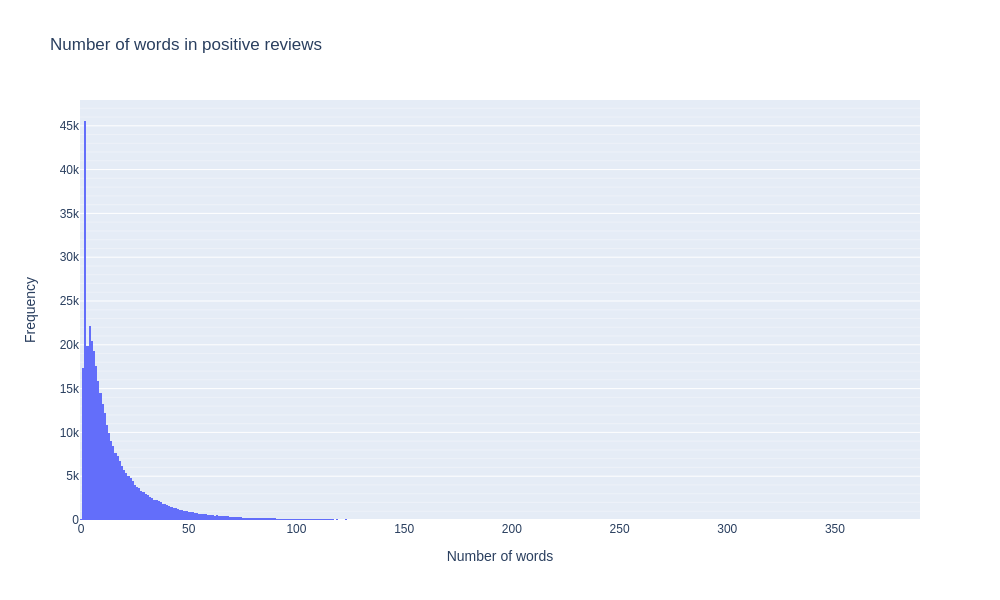

In [59]:
fig_pos_wc = px.histogram(
    X['pos_review_wc'],
    height=600,
    width=1000,
    title="Number of words in positive reviews"
)
fig_pos_wc.update_layout(showlegend=False)
fig_pos_wc.update_yaxes(minor_showgrid=True)
fig_pos_wc.layout.xaxis.title.text = 'Number of words'
fig_pos_wc.layout.yaxis.title.text = 'Frequency'
fig_pos_wc.write_html('images/pos_wc.html')
fig_pos_wc.write_image('images/pos_wc.png')
fig_pos_wc.show('png')
#fig_pos_wc.show()

The dependance is more smooth than that of negative reviews. Again most of reviews has very short duration, most of them admits quality of service. Long reviews tend to mark some insignificant flaws that can be fixed further.

In [60]:
X['positive_review'].value_counts(True)[:20]

positive_review
no positive                   0.069506
location                      0.022862
everything                    0.006342
nothing                       0.003353
great location                0.003338
the location                  0.003069
good location                 0.002903
breakfast                     0.001528
friendly staff                0.001409
excellent location            0.001231
staff                         0.001081
location and staff            0.000882
location staff                0.000814
location location location    0.000662
location was good             0.000628
location was great            0.000626
everything was perfect        0.000620
comfy bed                     0.000582
good breakfast                0.000574
perfect location              0.000548
Name: proportion, dtype: float64

In [61]:
pos_review_list = X['positive_review'].apply(lambda x: x.split())

In [62]:
pos_words_list = pos_review_list.explode()

Same concept as in negative reviews.

In [63]:
pos_words_cnt = pd.value_counts(pos_words_list)
pos_words_cnt.head(20)

positive_review
the          385768
and          315786
was          177057
staff        145804
very         144568
location     144555
to           140842
a            123577
room         105632
hotel         93507
in            85660
good          84479
of            79837
great         79156
is            76764
for           68502
were          68308
friendly      63869
breakfast     63297
helpful       57200
Name: count, dtype: int64

In [64]:
pos_words_cnt.drop(['the', 'and', 'was', 'very', 'to', 'a', 'in', 'of', 'is', 'for', 'were', 'we', 'with'], inplace=True)
pos_words_cnt.head(20)

positive_review
staff          145804
location       144555
room           105632
hotel           93507
good            84479
great           79156
friendly        63869
breakfast       63297
helpful         57200
nice            52026
clean           50249
excellent       46758
i               45769
comfortable     44843
it              37819
bed             37446
no              33827
from            32746
rooms           30345
at              27753
Name: count, dtype: int64

In [65]:
pos_words_cnt.drop(['i', 'it', 'no', 'from', 'rooms', 'at', 'on', 'all', 'you', 'are', 'stay', 'our', \
    'but', 'really', 'had', 'this', 'so', 'as', 'everything'], inplace=True)
pos_words_cnt.head(20)

positive_review
staff          145804
location       144555
room           105632
hotel           93507
good            84479
great           79156
friendly        63869
breakfast       63297
helpful         57200
nice            52026
clean           50249
excellent       46758
comfortable     44843
bed             37446
positive        27288
lovely          26269
close           23217
station         21952
perfect         19397
service         19392
Name: count, dtype: int64

In [66]:
pos_words_cnt.rename({'comfortable': 'comf'}, inplace=True)

In [67]:
positive_tags = list(pos_words_cnt[:20].index)
positive_tags

['staff',
 'location',
 'room',
 'hotel',
 'good',
 'great',
 'friendly',
 'breakfast',
 'helpful',
 'nice',
 'clean',
 'excellent',
 'comf',
 'bed',
 'positive',
 'lovely',
 'close',
 'station',
 'perfect',
 'service']

Generate some features marking presence of absence of word in positive review.

In [68]:
for tag in positive_tags:
    X['pos_is_' + tag] = X['positive_review'].apply(lambda x: 1 if tag in x else 0)

### Days since review

Match number of days from the feature.

In [69]:
X['reviewed_days_ago'] = X['days_since_review'].apply(lambda x: int(x.split()[0]))
X['reviewed_days_ago'].value_counts()

reviewed_days_ago
1      1911
322    1738
120    1702
338    1462
534    1451
       ... 
122     154
243     154
615     146
124     127
123     111
Name: count, Length: 731, dtype: int64

### Tags

Some preprocessing operations

In [70]:
# Delete square brackets and single quote then split the string into list of words
X['tags_list'] = X['tags'].apply(lambda x: re.sub('[\[\]\']', '', x).split(', '))
X['tags_list'].head()

0    [ Leisure trip ,  Couple ,  Studio Suite ,  St...
1    [ Business trip ,  Couple ,  Standard Double R...
2    [ Leisure trip ,  Solo traveler ,  Modern Doub...
3    [ Leisure trip ,  Solo traveler ,  Standard Ro...
4    [ Business trip ,  Couple ,  Standard Double o...
Name: tags_list, dtype: object

In [71]:
tags_flat = X['tags_list'].explode()

In [72]:
tag_list = list(tags_flat.value_counts().index)
tag_list[:10]

[' Leisure trip ',
 ' Submitted from a mobile device ',
 ' Couple ',
 ' Stayed 1 night ',
 ' Stayed 2 nights ',
 ' Solo traveler ',
 ' Stayed 3 nights ',
 ' Business trip ',
 ' Group ',
 ' Family with young children ']

In [73]:
# Filter tags containing 'night'
night_flat = [item for item in tags_flat if ' night' in item]
pd.value_counts(night_flat)

 Stayed 1 night                                 145373
 Stayed 2 nights                                100263
 Stayed 3 nights                                 72000
 Stayed 4 nights                                 35748
 Stayed 5 nights                                 15611
 Stayed 6 nights                                  7399
 Stayed 7 nights                                  5549
 Stayed 8 nights                                  1910
 Stayed 9 nights                                   966
 Stayed 10 nights                                  663
 Stayed 11 nights                                  306
 Stayed 12 nights                                  217
 Stayed 14 nights                                  184
 Stayed 13 nights                                  174
 Stayed 15 nights                                   87
 Stayed 16 nights                                   38
 Stayed 17 nights                                   27
 Stayed 18 nights                                   24
 Stayed 19

In [74]:
# Process 'Junior Suite Give me the night' case
night_flat = [' Stayed 1 night ' if item == ' Junior Suite Give me the night ' else item for item in night_flat]
pd.value_counts(night_flat)

 Stayed 1 night                                 145377
 Stayed 2 nights                                100263
 Stayed 3 nights                                 72000
 Stayed 4 nights                                 35748
 Stayed 5 nights                                 15611
 Stayed 6 nights                                  7399
 Stayed 7 nights                                  5549
 Stayed 8 nights                                  1910
 Stayed 9 nights                                   966
 Stayed 10 nights                                  663
 Stayed 11 nights                                  306
 Stayed 12 nights                                  217
 Stayed 14 nights                                  184
 Stayed 13 nights                                  174
 Stayed 15 nights                                   87
 Stayed 16 nights                                   38
 Stayed 17 nights                                   27
 Stayed 18 nights                                   24
 Stayed 19

Number of reviews who hasn't tag indicating number of nights stayed:

In [75]:
X['tags'].shape[0] - pd.value_counts(night_flat).sum()

136

Percent of reviews who hasn't tag indicating number of nights stayed:

In [76]:
round((1 - pd.value_counts(night_flat).sum() / X['tags'].shape[0]) * 100, 2)

0.04

Since we have only 0.04\% of reviews that doesn't indicate number of nights stayed, we can fill missing values.

In [77]:
night_list = list(pd.value_counts(night_flat).index)

In [78]:
def nights_num(feat):
    """Extract number of nights stayed or return np.nan otherwise

    Args:
        feat (pandas.Series): 'nights_stayed' feature

    Returns:
        stay_string (float): number of nights stayed or np.nan
    """
    
    for tag in feat:
        stay_string = np.nan
        
        if tag in night_list:
            stay_string = int(''.join(re.findall(r'\d+', tag)))
            break
    
    return stay_string

In [79]:
X['nights_stayed'] = X['tags_list'].apply(nights_num)
X['nights_stayed'].isna().value_counts()

nights_stayed
False    386657
True        146
Name: count, dtype: int64

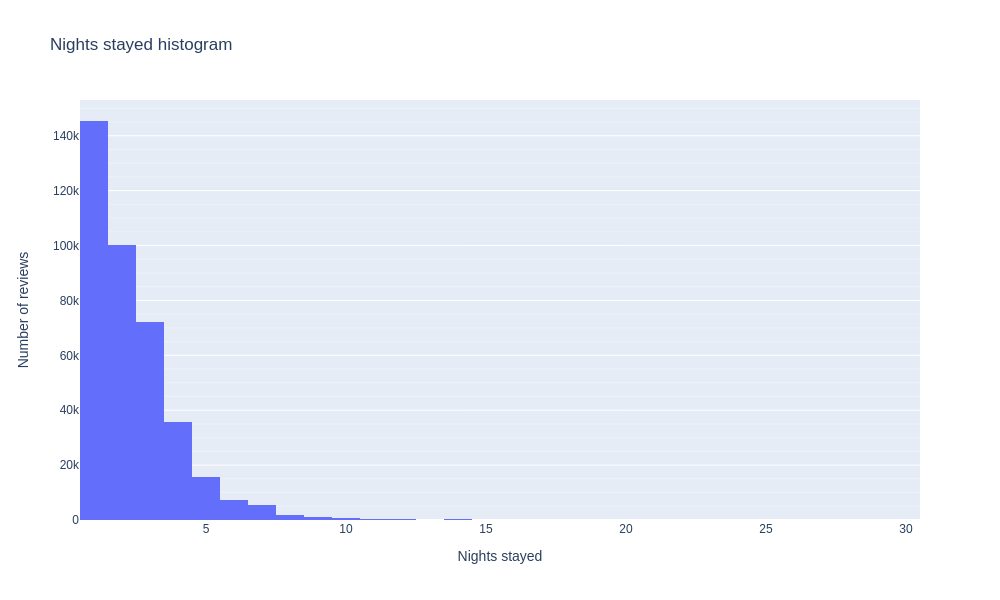

In [80]:
fig_nights = px.histogram(
    X['nights_stayed'].dropna().astype(int),
    height=600,
    width=1000,
    title="Nights stayed histogram"
)
fig_nights.update_layout(showlegend=False)
fig_nights.update_yaxes(minor_showgrid=True)
fig_nights.layout.xaxis.title.text = 'Nights stayed'
fig_nights.layout.yaxis.title.text = 'Number of reviews'
fig_nights.write_html('images/nights.html')
fig_nights.write_image('images/nights.png')
fig_nights.show('png')
#fig_nights.show()

The dependance is obviously far from normal, so missing values can be filled with median values.

In [81]:
X['nights_stayed'] = X['nights_stayed'].fillna(X['nights_stayed'].dropna().median()).astype(int)
X['nights_stayed'].head()

0    2
1    1
2    3
3    1
4    6
Name: nights_stayed, dtype: int64

Same concept as in negative reviews. Match 20 most popular tags.

In [82]:
pop_tags_list = [item for item in tag_list if ' night' not in item][:20]
display(pop_tags_list)

[' Leisure trip ',
 ' Submitted from a mobile device ',
 ' Couple ',
 ' Solo traveler ',
 ' Business trip ',
 ' Group ',
 ' Family with young children ',
 ' Double Room ',
 ' Standard Double Room ',
 ' Superior Double Room ',
 ' Family with older children ',
 ' Deluxe Double Room ',
 ' Double or Twin Room ',
 ' Standard Double or Twin Room ',
 ' Classic Double Room ',
 ' Superior Double or Twin Room ',
 ' 2 rooms ',
 ' Standard Twin Room ',
 ' Single Room ',
 ' Twin Room ']

Generate some features marking presence of absence of tag in tag list of review.

In [83]:
for tag in pop_tags_list:
    X['is' + tag.rstrip()] = X['tags_list'].apply(lambda x: 1 if tag in x else 0)

## Correlation analysis

In [84]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

Remove categorical features:

In [85]:
object_feats = X.select_dtypes(exclude=[np.number]).columns.values
display(object_feats)

array(['hotel_address', 'review_date', 'hotel_name',
       'reviewer_nationality', 'negative_review', 'positive_review',
       'tags', 'days_since_review', 'city', 'tags_list'], dtype=object)

In [86]:
X.drop(object_feats, axis=1, inplace=True)

Features with strong Spearman correlation:

In [87]:
X_corr_spearman = round(X.corr(method='spearman'), 2)
X_corr_sorted_spearman = X_corr_spearman.abs().unstack().sort_values(kind='quicksort', ascending=False)
spearman_corr_high = X_corr_sorted_spearman[(X_corr_sorted_spearman < 1) & (X_corr_sorted_spearman >= 0.7)]
spearman_corr_high

pos_review_wc                      review_total_positive_word_counts    0.99
review_total_positive_word_counts  pos_review_wc                        0.99
neg_review_wc                      review_total_negative_word_counts    0.97
review_total_negative_word_counts  neg_review_wc                        0.97
reviewed_days_ago                  review_year                          0.91
review_year                        reviewed_days_ago                    0.91
is Leisure trip                    is Business trip                     0.90
is Business trip                   is Leisure trip                      0.90
lng                                city_London                          0.87
city_London                        lng                                  0.87
additional_number_of_scoring       total_number_of_reviews              0.86
total_number_of_reviews            additional_number_of_scoring         0.86
dtype: float64

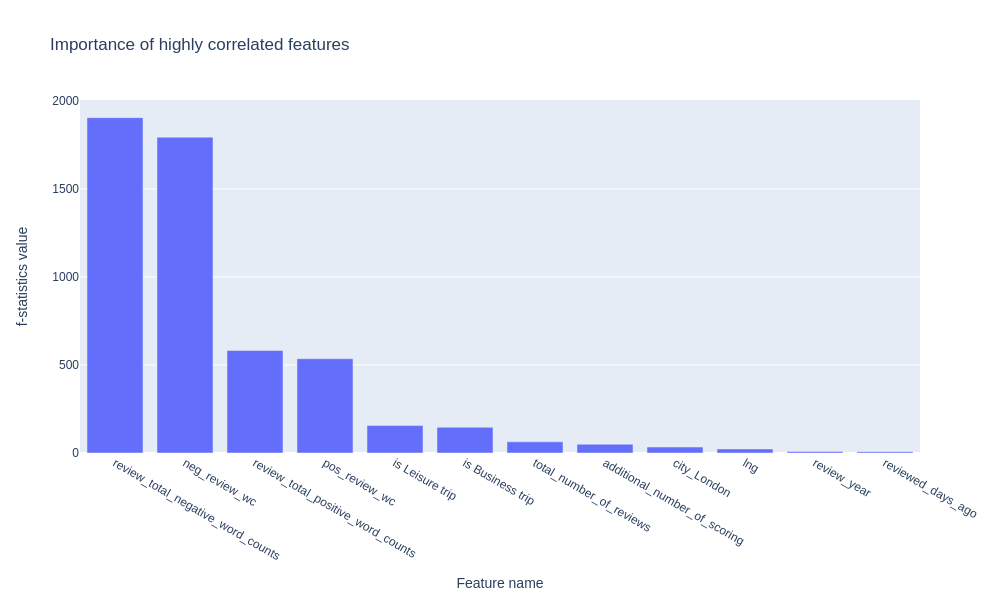

In [88]:
importance_corr_anova = pd.Series(f_classif(X[spearman_corr_high.unstack().columns], y)[0], \
    index = spearman_corr_high.unstack().columns)
importance_corr_anova.sort_values(inplace=True, ascending=False)

fig_imp_corr_anova = px.bar(
    importance_corr_anova,
    orientation='v',
    height=600,
    width=1000,
    title='Importance of highly correlated features'
)
fig_imp_corr_anova.update(layout_showlegend=False)
fig_imp_corr_anova.layout.xaxis.title.text = 'Feature name'
fig_imp_corr_anova.layout.yaxis.title.text = 'f-statistics value'
fig_imp_corr_anova.write_html('images/imp_corr_anova.html')
fig_imp_corr_anova.write_image('images/imp_corr_anova.png')
fig_imp_corr_anova.show('png')
# fig_imp_corr_anova.show()

Drop less important highly correlated features:

In [89]:
X.drop(['additional_number_of_scoring', 'neg_review_wc', 'pos_review_wc', 'reviewed_days_ago', 'is Business trip'], \
    axis=1, inplace=True)

Despite being more important 'city_London' will be removed:

In [90]:
X.drop(['city_London'], axis=1, inplace=True)

Features with strong Pearson correlation:

In [91]:
X_corr_pearson = round(X.corr(), 2)
X_corr_sorted_pearson = X_corr_pearson.abs().unstack().sort_values(kind='quicksort', ascending=False)
pearson_corr_high = X_corr_sorted_pearson[(X_corr_sorted_pearson < 1) & (X_corr_sorted_pearson >= 0.7)]
pearson_corr_high

lat             city_Barcelona    0.84
city_Barcelona  lat               0.84
lng             city_Vienna       0.82
city_Vienna     lng               0.82
dtype: float64

In [92]:
X.drop(['city_Barcelona', 'city_Vienna'], axis=1, inplace=True)

## Feature selection

In [93]:
# Number of features to transfer into the model
feat_num = 30

Most important features:

/home/teesuhkruta/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [14] are constant.

/home/teesuhkruta/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in divide



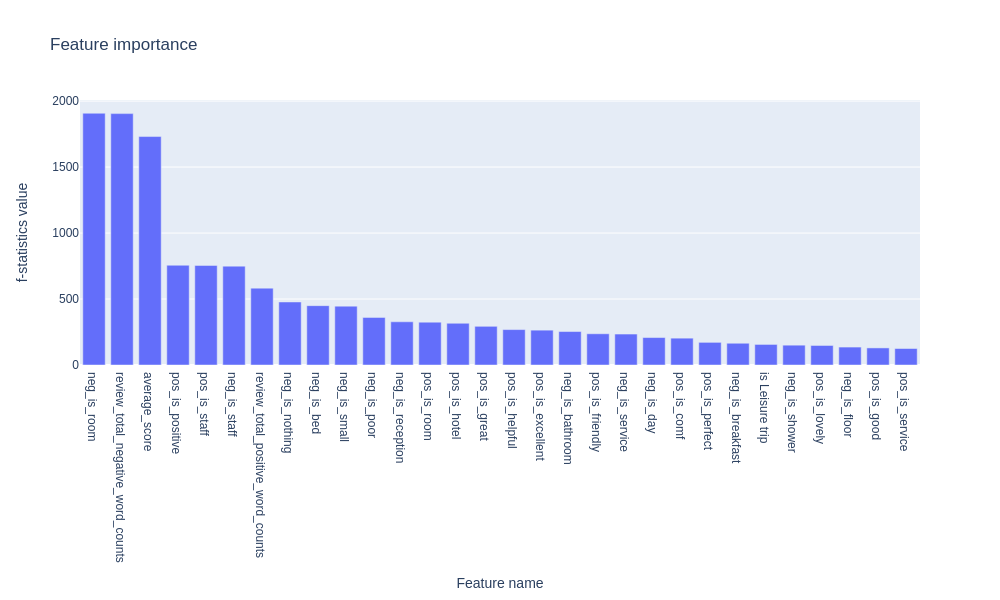

In [94]:
importance = pd.Series(f_classif(X, y)[0], index=X.columns)
importance.sort_values(inplace=True, ascending=False)

fig_kbest = px.bar(
    importance[:feat_num],
    orientation='v',
    height=600,
    width=1000,
    title='Feature importance'
)
fig_kbest.update(layout_showlegend=False)
fig_kbest.layout.xaxis.title.text = 'Feature name'
fig_kbest.layout.yaxis.title.text = 'f-statistics value'
fig_kbest.write_html('images/kbest.html')
fig_kbest.write_image('images/kbest.png')
fig_kbest.show('png')
#fig_kbest.show()

Generate dataframe containing most important features:

In [95]:
kbest_classifier = SelectKBest(score_func=f_classif, k=feat_num)
X_kbest = kbest_classifier.fit_transform(X, y)
mask = kbest_classifier.get_support()
kbest_feats = X.columns[mask]
kbest_df = pd.DataFrame(X_kbest, columns=kbest_feats)
kbest_df.head()

/home/teesuhkruta/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [14] are constant.

/home/teesuhkruta/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in divide



,average_score,review_total_negative_word_counts,review_total_positive_word_counts,neg_is_room,neg_is_breakfast,neg_is_small,neg_is_staff,neg_is_nothing,neg_is_bed,neg_is_bathroom,...,pos_is_great,pos_is_friendly,pos_is_helpful,pos_is_excellent,pos_is_comf,pos_is_positive,pos_is_lovely,pos_is_perfect,pos_is_service,is Leisure trip
0,8.4,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,8.3,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.9,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,7.5,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,8.5,4.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model creation

In [96]:
from sklearn.model_selection import train_test_split

In [97]:
# Split the data on test and train samples 
X_train, X_test, y_train, y_test = train_test_split(kbest_df, y, test_size=0.25, random_state=42)

In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [99]:
# Model creation 
regr = RandomForestRegressor(n_estimators=100)

In [100]:
# Learn the model on test sample
regr.fit(X_train, y_train)  

RandomForestRegressor()

In [101]:
# Hotel rating prediction
y_pred = regr.predict(X_test)
# MAPE value
print(f'MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred) * 100:.3f} %')

MAPE: 13.200 %
